# 🔹 Block 1 – Imports & Config

In [26]:
import os
import cv2
import exifread
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Re-use Week 1 utilities
from Week1_25100190_25100334 import (
    preprocess_image,
    match_features,
    visualize_matches
)

DATA_DIR = "./Dataset/Option 1/"
RESIZE_WIDTH = 1500
USE_PREPROCESS = True

IMG_IDX1 = 9
IMG_IDX2 = 14

RATIO_TEST = 0.7
ESS_RANSAC_THRESH = 1.0
MIN_INLIERS = 50
OUTPUT_PLY = "week2_two_view_cloud.ply"


# Load Images

In [ ]:
def load_images_from_folder(folder, resize_width=None):
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Folder does not exist: {folder}")

    images = []
    paths = []

    valid_ext = (".jpg", ".jpeg", ".png", ".JPG", ".PNG")

    files = sorted(os.listdir(folder))
    for filename in files:
        if filename.lower().endswith(valid_ext):
            path = os.path.join(folder, filename)
            img = cv2.imread(path)

            if img is None:
                print(f"Failed to read image: {path}")
                continue

            if resize_width is not None:
                h, w = img.shape[:2]
                scale = resize_width / w
                img = cv2.resize(img, (resize_width, int(h * scale)))

            images.append(img)
            paths.append(path)

    if len(images) == 0:
        raise FileNotFoundError(f"No images found in {folder}")

    return images, paths


#  Block 2 – Intrinsics from EXIF

In [ ]:
def _read_exif_tags(image_path):
    with open(image_path, "rb") as f:
        tags = exifread.process_file(f, details=False)
    return tags


def _parse_rational(tag):
    if tag is None:
        return None
    try:
        val = tag.values[0]
        return float(val.num) / float(val.den)
    except Exception:
        try:
            return float(str(tag))
        except Exception:
            return None

def compute_intrinsics_for_image(image_path, img_shape, resized_width=None):
    H, W = img_shape[:2]

    tags = _read_exif_tags(image_path)

    focal_35 = _parse_rational(tags.get("EXIF FocalLengthIn35mmFilm"))
    focal_mm = _parse_rational(tags.get("EXIF FocalLength"))

    print(f"focal_35mm = {focal_35}")
    print(f"focal_mm   = {focal_mm}")
    print(f"image size = {W} × {H}")

    if focal_35 is not None:
        fx = fy = (focal_35 / 36.0) * W

    elif focal_mm is not None:
        SENSOR_WIDTH_MM = 7.6
        fx = fy = (focal_mm / SENSOR_WIDTH_MM) * W
        print("Using estimated sensor width!")

    else:
        print("No focal information found!")
        fx = fy = W

    cx = W / 2
    cy = H / 2

    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])

    if resized_width is not None and resized_width != W:
        s = resized_width / W
        K[0, 0] *= s
        K[1, 1] *= s
        K[0, 2] *= s
        K[1, 2] *= s
        print(f"[INFO] Applied resize scale {s:.4f}")

    print("K =\n", K)
    return K



#  Block 3 – Essential matrix, pose recovery, triangulation

In [23]:
import numpy as np
import cv2

def build_projection_matrices(K, R, t):
    P0 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P1 = K @ np.hstack((R, t))
    return P0, P1

def extract_colors(img, pts_2d):
    colors = []
    H, W = img.shape[:2]

    for (x, y) in pts_2d:
        x_int = int(round(x))
        y_int = int(round(y))

        if 0 <= x_int < W and 0 <= y_int < H:
            b, g, r = img[y_int, x_int]
            colors.append([r/255.0, g/255.0, b/255.0])
        else:
            colors.append([1, 1, 1])

    return np.array(colors)


def triangulate_points(K, R, t, pts1, pts2):
    P0 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
    P1 = K @ np.hstack((R, t))

    pts4D = cv2.triangulatePoints(P0, P1, pts1.T, pts2.T)
    pts3D = (pts4D[:3] / pts4D[3]).T

    z1 = pts3D[:,2]

    pts3D_cam2 = (R @ pts3D.T + t).T
    z2 = pts3D_cam2[:,2]

    valid_mask = (z1 > 0) & (z2 > 0)
    pts3D_valid = pts3D[valid_mask]

    print(f"[Triangulation] total={pts3D.shape[0]} valid={pts3D_valid.shape[0]}")

    return pts3D_valid, valid_mask


#  Block 4 – Save PLY & visualize


In [24]:
import open3d as o3d
import matplotlib.pyplot as plt

def save_point_cloud(points_3d, colors, output_path):
    if points_3d.size == 0:
        print("No points to save!")
        return

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    o3d.io.write_point_cloud(output_path, pcd)
    print(f"point cloud saved as {output_path}")

def crop_extreme_points(points, colors, percentile=95):
    centroid = np.mean(points, axis=0)
    dists = np.linalg.norm(points - centroid, axis=1)
    thresh = np.percentile(dists, percentile)
    mask = dists <= thresh
    return points[mask], colors[mask]


def plot_3d_views(points_3d, colors):
    if points_3d.shape[0] == 0:
        print("No 3D points to plot.")
        return

    points_3d, colors = crop_extreme_points(points_3d, colors, percentile=95)

    X = points_3d[:, 0]
    Y = points_3d[:, 1]
    Z = points_3d[:, 2]

    fig = plt.figure(figsize=(18, 12))
    fig.patch.set_facecolor("white")

    # 3D VIEW
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X, Y, Z, s=3, c=colors)
    ax1.set_title("3D View (RGB)")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # TOP VIEW (X-Y)
    ax2 = fig.add_subplot(132)
    ax2.scatter(X, Y, s=3, c=colors)
    ax2.set_title("Top View (X-Y)")
    ax2.set_aspect('equal', 'box')

    # SIDE VIEW (X-Z)
    ax3 = fig.add_subplot(133)
    ax3.scatter(X, Z, s=3, c=colors)
    ax3.set_title("Side View (X-Z)")
    ax3.set_aspect('equal', 'box')

    # # FRONT VIEW (Y-Z)
    # ax4 = fig.add_subplot(234)
    # ax4.scatter(Y, Z, s=3, c=colors)
    # ax4.set_title("Front View (Y-Z)")
    # ax4.set_aspect('equal', 'box')

    # # Rotated views
    # ax5 = fig.add_subplot(235, projection='3d')
    # ax5.scatter(X, Y, Z, s=3, c=colors)
    # ax5.view_init(elev=20, azim=120)

    # ax6 = fig.add_subplot(236, projection='3d')
    # ax6.scatter(X, Y, Z, s=3, c=colors)
    # ax6.view_init(elev=60, azim=10)

    plt.tight_layout()
    plt.show()


def visualize_inliers(img1, img2, kp1, kp2, matches, inlier_mask):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)

    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    inlier_color = (0, 255, 0)
    outlier_color = (0, 0, 255)

    for match, is_inl in zip(matches, inlier_mask):
        pt1 = tuple(np.int32(kp1[match.queryIdx].pt))
        pt2 = (np.int32(kp2[match.trainIdx].pt)[0] + w1,
               np.int32(kp2[match.trainIdx].pt)[1])

        if is_inl:
            cv2.line(canvas, pt1, pt2, inlier_color, 1)
            cv2.circle(canvas, pt1, 2, inlier_color, -1)
            cv2.circle(canvas, pt2, 2, inlier_color, -1)
        else:
            cv2.line(canvas, pt1, pt2, outlier_color, 1)
            cv2.circle(canvas, pt1, 2, outlier_color, -1)
            cv2.circle(canvas, pt2, 2, outlier_color, -1)

    return canvas

def visualize_inlier_matches_only(img1, img2, kp1, kp2, matches, inlier_mask):
    inlier_matches = [m for m, v in zip(matches, inlier_mask) if v]

    img = cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        inlier_matches,
        None,
        matchColor=(0,255,0),
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return img

#  Main Run


Loaded 24 images from ./Dataset/Option 1/
Using images 9 and 14
Image 1 shape: (1999, 1500, 3)
Image 2 shape: (1999, 1500, 3)
Applied preprocessing to both images.
focal_35mm = 24.0
focal_mm   = 6.764999865652793
image size = 1500 × 1999
K =
 [[1000.     0.   750. ]
 [   0.  1000.   999.5]
 [   0.     0.     1. ]]
1675 good matches out of 63779 total
Total good matches: 1675


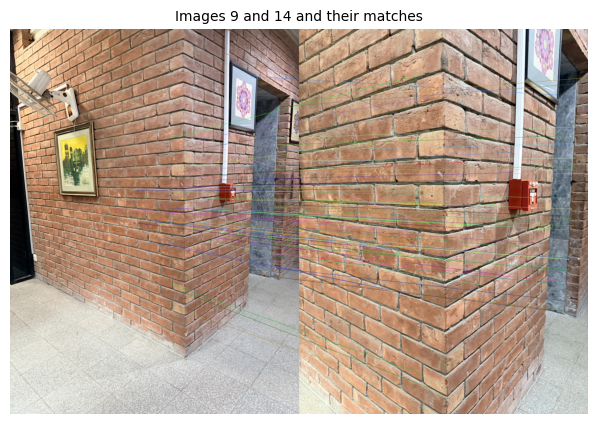

Inliers after EssentialMat RANSAC: 1186 / 1675


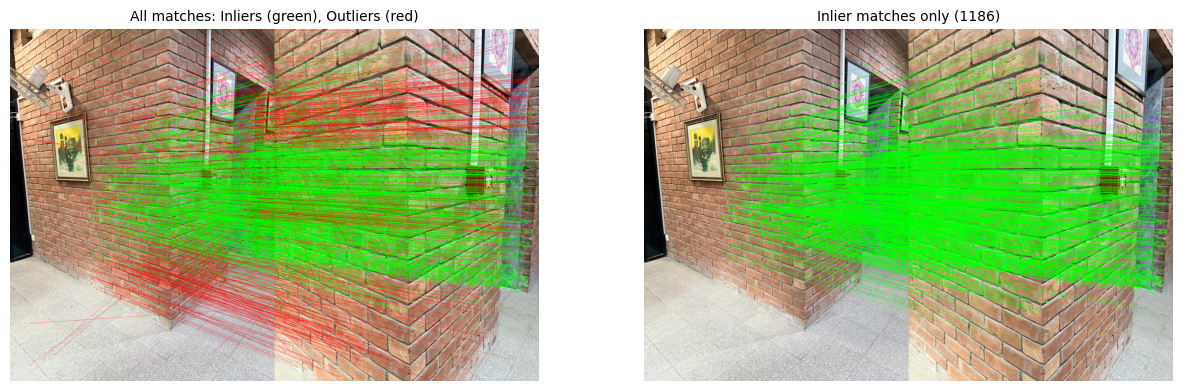

Essential matrix singular values: [7.07106781e-01 7.07106781e-01 4.20755616e-17]
recoverPose inliers: 1186
Recovered R:
 [[ 9.94002660e-01  3.01545798e-04 -1.09355477e-01]
 [ 5.36502242e-03  9.98657555e-01  5.15199394e-02]
 [ 1.09224209e-01 -5.17976514e-02  9.92666649e-01]]
Recovered t
 [-0.07531566  0.04352655 -0.99620931]
[Triangulation] total=1186 valid=1186


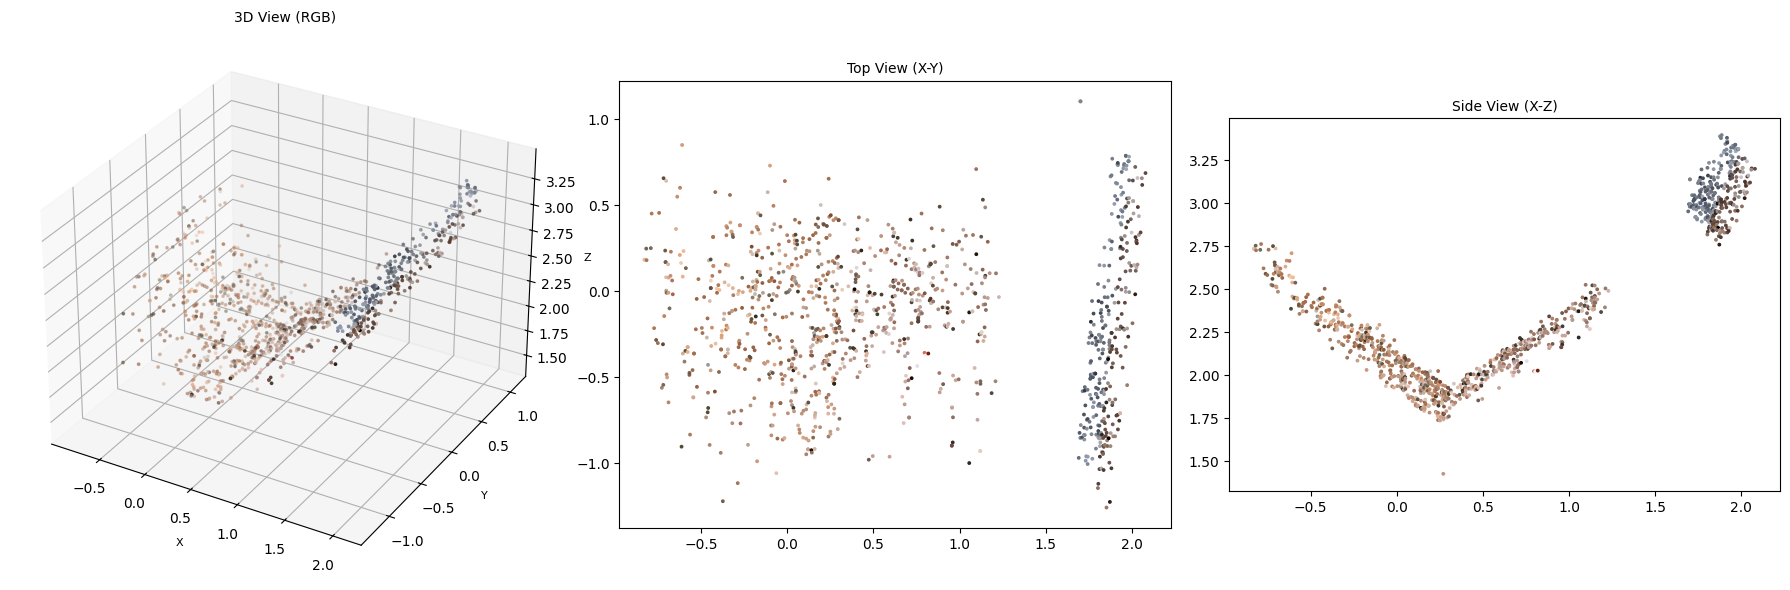

point cloud saved as week2_two_view_cloud.ply


In [27]:

def run_two_view_reconstruction():
    images, paths = load_images_from_folder(DATA_DIR, resize_width=RESIZE_WIDTH)
    print(f"Loaded {len(images)} images from {DATA_DIR}")
    print(f"Using images {IMG_IDX1} and {IMG_IDX2}")

    img1 = images[IMG_IDX1]
    img2 = images[IMG_IDX2]
    path1 = paths[IMG_IDX1]
    path2 = paths[IMG_IDX2]

    print("Image 1 shape:", img1.shape)
    print("Image 2 shape:", img2.shape)

    if USE_PREPROCESS:
        proc1 = preprocess_image(img1)
        proc2 = preprocess_image(img2)
        print("Applied preprocessing to both images.")
    else:
        proc1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        proc2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        print("Using plain grayscale images.")

    K = compute_intrinsics_for_image(
        path1,
        img1.shape,
        resized_width=RESIZE_WIDTH
    )

    kp1, kp2, good_matches = match_features(proc1, proc2, ratio_thresh=RATIO_TEST)
    print(f"Total good matches: {len(good_matches)}")

    if len(good_matches) < MIN_INLIERS:
        print(f"Very few matches ({len(good_matches)}). "
              f"Try another image pair or adjust RATIO_TEST.")

    vis = visualize_matches(img1, img2, kp1, kp2, good_matches,
                            title=f"Img {IMG_IDX1} <-> {IMG_IDX2}")
    plt.figure(figsize=(10, 5))
    plt.imshow(vis)
    plt.title(f"Images {IMG_IDX1} and {IMG_IDX2} and their matches")
    plt.axis('off')
    plt.show()

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    E, mask_E = cv2.findEssentialMat(
        pts1, pts2, K,
        method=cv2.RANSAC,
        prob=0.999,
        threshold=ESS_RANSAC_THRESH
    )

    if E is None:
        raise RuntimeError("findEssentialMat failed. Check matches and K.")

    inliers_mask = mask_E.ravel().astype(bool)
    inliers1 = pts1[inliers_mask]
    inliers2 = pts2[inliers_mask]
    print(f"Inliers after EssentialMat RANSAC: {inliers1.shape[0]} / {pts1.shape[0]}")

    fig = plt.figure(figsize=(15, 6))

    canvas_all = visualize_inliers(img1, img2, kp1, kp2, good_matches, inliers_mask)
    canvas_clean = visualize_inlier_matches_only(img1, img2, kp1, kp2, good_matches, inliers_mask)

    plt.subplot(1, 2, 1)
    plt.imshow(canvas_all[:, :, ::-1])
    plt.title("All matches: Inliers (green), Outliers (red)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(canvas_clean[:, :, ::-1])
    plt.title(f"Inlier matches only ({np.sum(inliers_mask)})")
    plt.axis('off')

    plt.show()

    U, S, Vt = np.linalg.svd(E)
    print("Essential matrix singular values:", S)

    if inliers1.shape[0] < MIN_INLIERS:
        print("Very few inliers. Result may be unstable.")

    num_inliers, R, t, mask_pose = cv2.recoverPose(E, inliers1, inliers2, K)
    print(f"recoverPose inliers: {num_inliers}")
    print("Recovered R:\n", R)
    print("Recovered t\n", t.ravel())

    points_3d, valid_mask = triangulate_points(K, R, t, inliers1, inliers2)
    valid_inliers1 = inliers1[valid_mask]
    colors = extract_colors(img1, valid_inliers1)

    plot_3d_views(points_3d, colors)

    save_point_cloud(points_3d, colors, OUTPUT_PLY)


if __name__ == "__main__":
    run_two_view_reconstruction()
